## Introduction and Objective

In research of freezing of gait for patients with parkinson's disease, I came across a research paper that explained the phenomena and its challenges quite well. The following information is from [Freezing of gait: moving forward on a mysterious clinical phenomenon (Nutt et. al.)](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC7293393/)
<br></br>
Freezing of gait (FoG) is a disabling clinical phenomenon common in advanced Parkinson’s disease (PD). Although it is easy to recognize, the phenomenon is pretty difficult to define. This is due to the definition including a variety of episodes:

1. inability to initiate gait (“start hesitation”) 
2. arrests in forward progression during walking (“turn” hesitation)
3. as well as episodes of shuffling forward with steps that are millimetres to a couple of centimetres in length

FoG can last anywhere from a few seconds, which is most common, to over 30 seconds. FoG also seems to be nearly continuous meaning that the patient is inable to generate any steps long enough to provide useful assistance (or not) in moving their bodies forward. Several important features have been found to accompany FoG:
<br>
(1) the foot or toe does not leave the ground or only barely clears the support surface; 
<br>
(2) alternate trembling of the legs occurs at a frequency of 3–8 Hz;
<br>
(3) hastening, or an increase in cadence with a decrease in step length, often precedes FoG; 
<br>
(4) a subjective feeling of the feet being glued to the floor accompanies episodes of freezing; 
<br>
(5) FoG is commonly precipitated or relieved by various cues; and (6) FoG can be asymmetrical, affecting mainly one foot or being elicited more easily by turning in one direction.
<br></br>
Due to this varied definition with a collective of features, FoG appears to be able to represent several different syndromes with different underlying mechanisms. Three different patterns have been suggested for FoG: 
<br>
(1) trembling in place: alternating tremor of the legs (knees); 
<br>
(2) shuffling forward: very short, shuffling steps; 
<br>
(3) complete akinesia: no movement of the limbs or trunk, but this pattern is uncommon.
<br>

The objective of this notebook is to model 3D lower-back sensor data to be able to model event types that indicate freezing of gait, ultimately helping researchers better understand when and why FOG episodes occur.

## Dataset Curation and Modeling Overview
Here's a quick recap of the 3 datasets that were initially provided in the competition:
<br>
1. The tDCS FOG (tdcsfog) dataset, comprising data series collected in the lab, as subjects completed a FOG-provoking protocol.
2. The DeFOG (defog) dataset, comprising data series collected in the subject's home, as subjects completed a FOG-provoking protocol.
3. The Daily Living (daily) dataset, comprising one week of continuous 24/7 recordings from sixty-five subjects. Forty-five subjects exhibit FOG symptoms and also have series in the defog dataset, while the other twenty subjects do not exhibit FOG symptoms and do not have series elsewhere in the data.
<br>
Trials from the tdcsfog and defog datasets were videotaped and annotated by expert reviewers documented the freezing of gait episodes. That is, the start, end and type of each episode were marked by the experts. Series in the daily dataset are unannotated. You will be detecting FOG episodes for the tdcsfog and defog series. You may wish to apply unsupervised or semi-supervised methods to the series in the daily dataset to support your detection modelling.

Since the evaluation criteria will be only on valid examples, we will only be using valid, annotated records in our supervised learning models. Some key notes on the datasets:
- the tDCS FOG dataset is all valid examples with annotated labels of event types
- the tDCS FOG dataset recorded acceleration at 128 Hz in units of m/s^2
- the DeFOG dataset has a combination of valid and invalid examples where invalid resembles examples that experts were inable to distinguish the appropriate event type label
- the DeFOG dataset recorded acceleration at 100 Hz in units of g.
- the Daily Living dataset is unannotated, but recorded acceleration the same as the DeFOG dataset.
<br>

The DeFOG dataset will first be filtered to only valid examples; according to the data dictionary this corresponds to where "Valid" = 1 and "Task" = 1. This isn't relevant for the tDCS FOG dataset. Additionally, each dataset will get joined to its corresponding metadata file to incorporate medication data.

Our baseline will be leveraging only the acceleration features to predict for our target variable (EventType, which will need to be created) and over time feature engineering will be employed to incorporate time-based features as well. The dataset being at the sub-second level makes it difficult to incorporate features from the subject, tasks, events, and metadata files.

Due to the differences in data collection, units, and environment between the two main datasets, I will create a model for each and ensemble the two together via a VotingClassifier which will be leveraged on the test set. This will allow for each model to pick up on the subtle patterns in each environment's accelerometer data while also covering for the potential biases of the other.

## Data Preprocessing and EDA

### Setup and Helper Functions

In [1]:
# Imports and constant variables

import pandas as pd
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from scipy.stats import pearsonr
from sklearn.preprocessing import LabelEncoder
from sklearn.utils.class_weight import compute_class_weight
from sklearn.model_selection import train_test_split
import xgboost as xgb
import hyperopt
from hyperopt import fmin, hp, tpe, rand, Trials, STATUS_OK
from hyperopt.early_stop import no_progress_loss
from hyperopt.pyll.base import scope
from sklearn.calibration import CalibratedClassifierCV
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score
)
from seglearn.feature_functions import base_features, emg_features
from tsflex.features import FeatureCollection, MultipleFeatureDescriptors
from tsflex.features.integrations import seglearn_feature_dict_wrapper

MAIN_ROOT = 'C:/Users/anima/Documents/Parkinsons FoG Kaggle'
DEFOG_PATH = f'{MAIN_ROOT}/train/defog/'
DEFOG_METADATA_PATH = f'{MAIN_ROOT}/defog_metadata.csv'
TDCSFOG_PATH = f'{MAIN_ROOT}/train/tdcsfog/'
TDCSFOG_METADATA_PATH = f'{MAIN_ROOT}/tdcsfog_metadata.csv'
DEFOG_TEST_PATH = f'{MAIN_ROOT}/test/defog/'
TDCSFOG_TEST_PATH = f'{MAIN_ROOT}/test/tdcsfog/'

RANDOM_SEED = 0

c:\Users\anima\anaconda3\envs\parkinsons_fog_kaggle\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Reduce Memory Usage
# reference : https://www.kaggle.com/code/arjanso/reducing-dataframe-memory-size-by-65 @ARJANGROEN

def reduce_memory_usage(df):
    
    start_mem = df.memory_usage().sum() / 1024**2
    # print('Memory usage of dataframe is {:.2f} MB'.format(start_mem))
    
    for col in df.columns:
        col_type = df[col].dtype.name
        if ((col_type != 'datetime64[ns]') & (col_type != 'category')):
            if (col_type != 'object'):
                c_min = df[col].min()
                c_max = df[col].max()

                if str(col_type)[:3] == 'int':
                    if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                        df[col] = df[col].astype(np.int8)
                    elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                        df[col] = df[col].astype(np.int16)
                    elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                        df[col] = df[col].astype(np.int32)
                    elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                        df[col] = df[col].astype(np.int64)

                else:
                    if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                        df[col] = df[col].astype(np.float16)
                    elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                        df[col] = df[col].astype(np.float32)
                    else:
                        pass
            else:
                df[col] = df[col].astype('category')
    mem_usg = df.memory_usage().sum() / 1024**2 
    # print("Memory usage became: ",mem_usg," MB")
    
    return df

In [3]:
# Helper functions for visualizations

def plot_value_counts_bar_chart(df, column):
    """
    Creates bar chart for one column based on the value counts for its unique values. Best for small number of unique integer values.
    Args:
        df: dataframe to visualize
        column: column in cleaned dataframe that has numeric values.
    Returns:
        bar chart showing value counts of each integer values in the column. Max value is colored.
    """

    df_viz = df[column].value_counts().reset_index()
    values = df[column].value_counts().reset_index().sort_values('index')[column].values
    colors = ['slategrey' if (x < max(values)) else 'deeppink' for x in values]

    fig, ax = plt.subplots(figsize=(25,5))

    ax = sns.barplot(
        data=df_viz, 
        x=df_viz['index'], 
        y=df_viz[column], 
        palette=colors
    )

    ax.set(xlabel=column)
    ax.set(ylabel='Counts')
    ax.set_title(f'{column} Value Counts')
    custom_style = {
        'axes.labelcolor': 'black',
        'xtick.color': 'black',
        'ytick.color': 'black',
        'font.size': 12
    }
    ax = sns.set_style('darkgrid', rc=custom_style)
    plt.show()
    
def plot_numerical_distribution(df, column):
    """
    Creates histogram for one numerical column. Best for columns with float dtype.
    Args:
        df: dataframe to visualize
        column: column in cleaned dataframe that has numeric values.
    Returns:
        histogram chart showing the column's distribution.
    """
    k2, p = stats.normaltest(df[column])
    alpha = 1e-3
    if p < alpha:
        color = 'slategrey'
    else:
        color = 'deeppink'

    fig, ax = plt.subplots(figsize=(25,5))

    ax = sns.histplot(
        data=df, 
        x=df[column], 
        stat='density', 
        kde=True, 
        color=color
    )

    ax.set(xlabel=column)
    ax.set_title(f'{column} Distribution, p = {p}')
    custom_style = {
        'axes.labelcolor': 'black',
        'xtick.color': 'black',
        'ytick.color': 'black',
        'font.size': 12
    }
    ax = sns.set_style('darkgrid', rc=custom_style)
    plt.show()
    
def plot_line_chart(df, x, y, hue=None):
    """
    Creates line chart for one column with optional hue for multiple lines.
    Args:
        df: dataframe to visualize
        x: column in cleaned dataframe that is the time value
        y: values to plot over time
    Returns:
        line chart of selected values over time
    """
    palette = sns.color_palette('flare', n_colors=3)

    fig, ax = plt.subplots(figsize=(25,5))

    ax = sns.lineplot(
        data=df, 
        x=df[x], 
        y=df[y], 
        hue=hue,
        palette=palette
    )

    ax.set(xlabel=x)
    ax.set(ylabel=y)
    ax.set_title(f'{y} Over Time')
    custom_style = {
        'axes.labelcolor': 'black',
        'xtick.color': 'black',
        'ytick.color': 'black',
        'font.size': 12
    }
    ax = sns.set_style('darkgrid', rc=custom_style)
    plt.show()

### Exploring Subjects

In [4]:
# Read in subjects file

subjects = pd.read_csv(
    f'{MAIN_ROOT}/subjects.csv',
    index_col='Subject')
subjects = reduce_memory_usage(subjects)

subjects

,Visit,Age,Sex,YearsSinceDx,UPDRSIII_On,UPDRSIII_Off,NFOGQ
Subject,,,,,,,
04fcdb,1.0,63,M,3.0,30.0,NaN,0
05595e,1.0,56,M,8.0,28.0,NaN,0
0967b2,1.0,59,M,10.0,38.0,48.0,19
0967b2,2.0,59,M,10.0,37.0,44.0,13
097078,NaN,70,F,10.0,27.0,50.0,20
...,...,...,...,...,...,...,...
f90887,1.0,72,M,16.0,35.0,46.0,26
fc1e1b,1.0,82,F,11.0,38.0,42.0,21
fe5d84,2.0,72,M,14.0,32.0,45.0,17


M    121
F     52
Name: Sex, dtype: int64


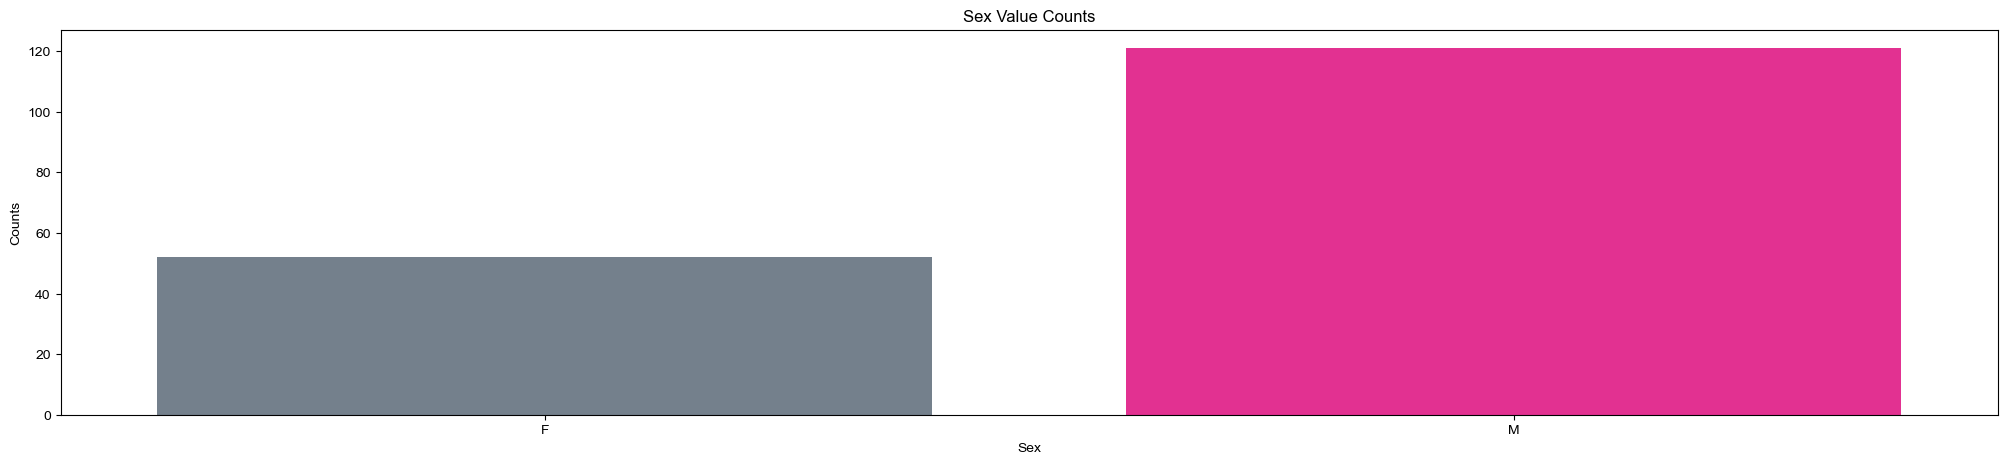

In [6]:
print(subjects['Sex'].value_counts())
plot_value_counts_bar_chart(subjects, 'Sex')

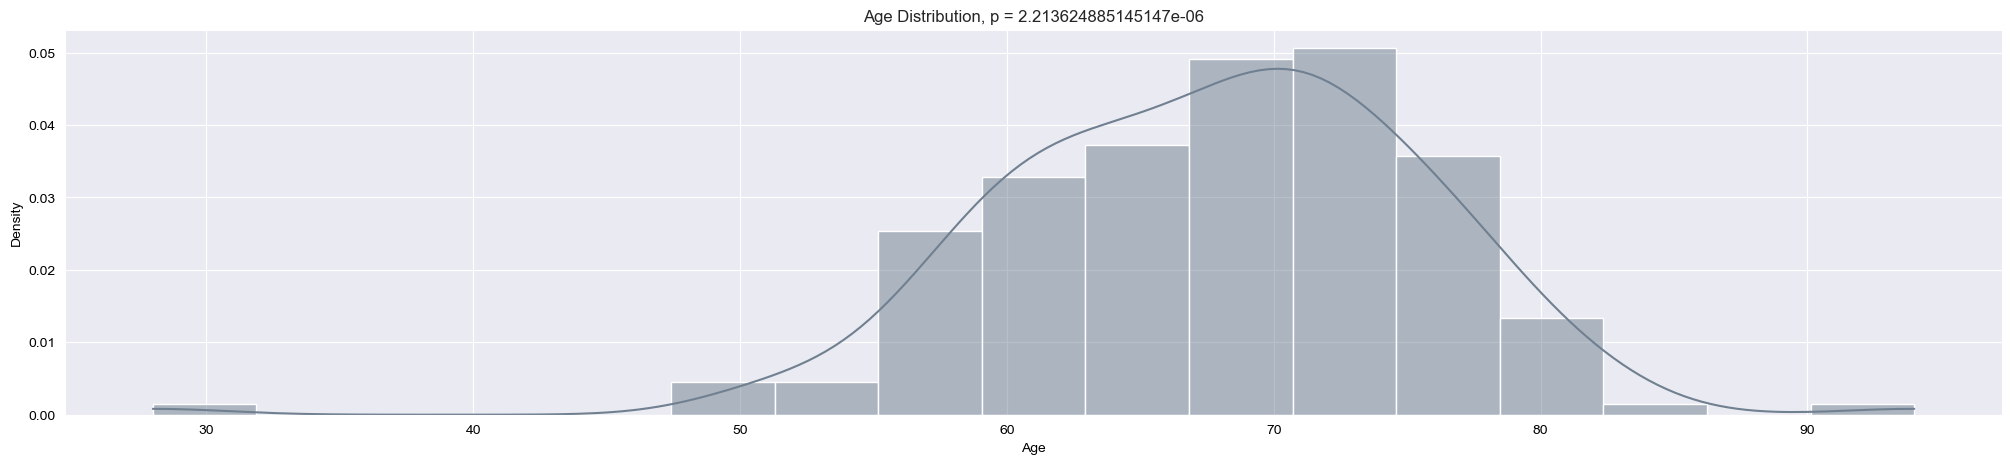

In [7]:
plot_numerical_distribution(subjects, 'Age')

### Preprocessing and Exploring DeFOG Dataset

In [8]:
# Read in all defog train files. Creating time based features for window of 100 due to DeFOG files read in at 100Hz. Stride is at 50 so model can pick up time continuity in the overlap.

defog_files = Path(DEFOG_PATH).glob('*.csv')
train_defog = pd.concat(
    (pd.read_csv(f).assign(FileName=f.stem) for f in defog_files), 
    ignore_index=True
)
train_defog = reduce_memory_usage(train_defog)
train_defog.set_index(['FileName'], inplace=True)
train_defog

,Time,AccV,AccML,AccAP,StartHesitation,Turn,Walking,Valid,Task
FileName,,,,,,,,,
02ea782681,0,-1.000000,0.044128,-0.250000,0,0,0,0.0,0.0
02ea782681,1,-1.000000,0.034424,-0.250000,0,0,0,0.0,0.0
02ea782681,2,-1.000000,0.031250,-0.250000,0,0,0,0.0,0.0
02ea782681,3,-1.000000,0.031250,-0.250000,0,0,0,0.0,0.0
02ea782681,4,-1.000000,0.031250,-0.250000,0,0,0,0.0,0.0
...,...,...,...,...,...,...,...,...,...
f9fc61ce85,120027,-0.962402,0.113281,-0.328369,0,0,0,0.0,0.0
f9fc61ce85,120028,-0.962402,0.109253,-0.324951,0,0,0,0.0,0.0
f9fc61ce85,120029,-0.956055,0.101685,-0.324463,0,0,0,0.0,0.0


0.0    9414380
1.0    4111322
Name: Valid, dtype: int64


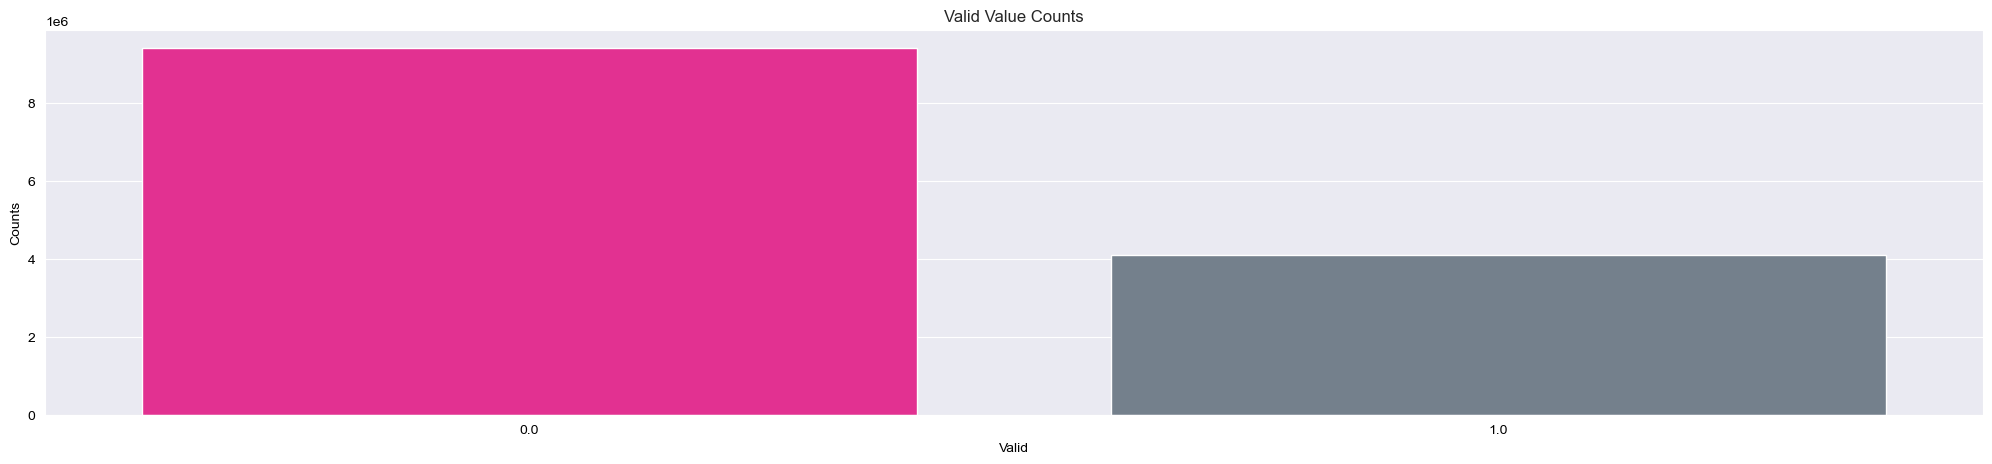

In [9]:
print(train_defog['Valid'].value_counts())
plot_value_counts_bar_chart(train_defog, 'Valid')

0.0    9379725
1.0    4145977
Name: Task, dtype: int64


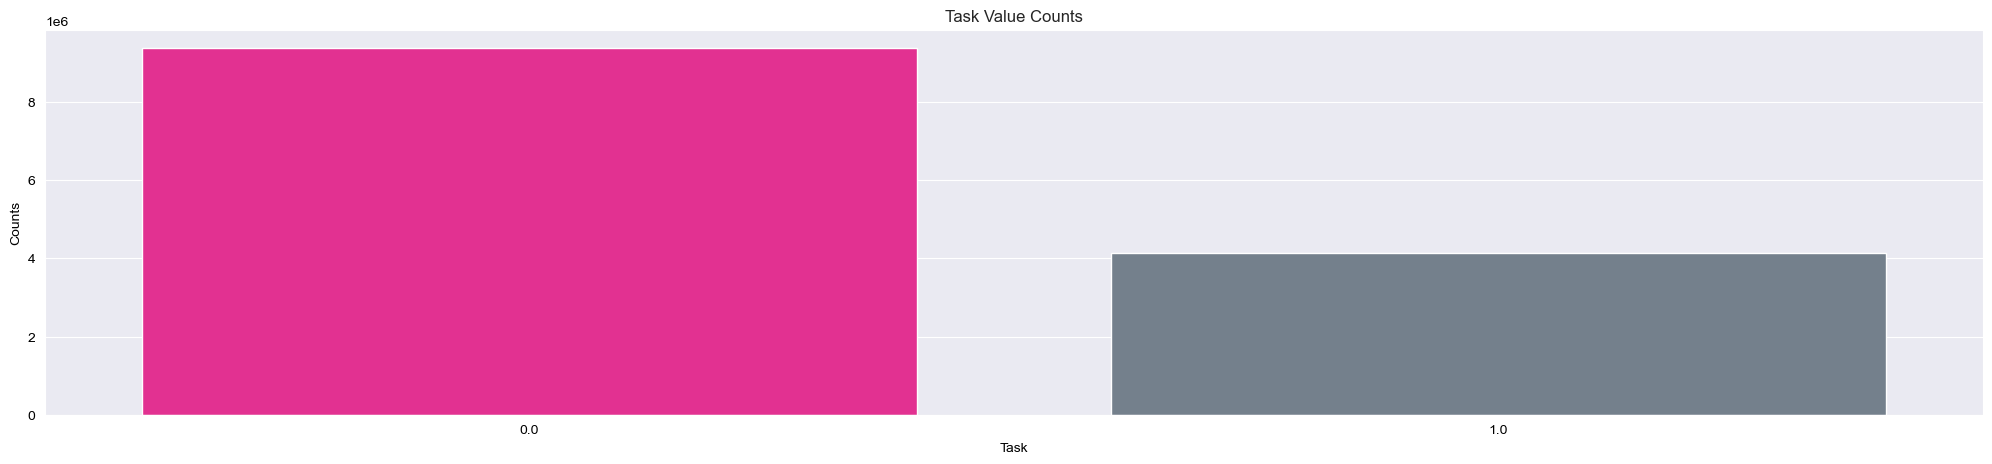

In [10]:
print(train_defog['Task'].value_counts())
plot_value_counts_bar_chart(train_defog, 'Task')

In [11]:
# Filtering to only valid records

train_defog_valid = train_defog[(train_defog['Valid'] == 1) & (train_defog['Task'] == 1)].drop(columns=['Valid', 'Task'])
train_defog_valid.shape

(4111322, 7)

In [12]:
# This takes forever to run, so uncommenting for now

# defog_acceleration_timesteps = train_defog_valid[['Time', 'AccV', 'AccML', 'AccAP']].reset_index(drop=True).set_index('Time').stack().reset_index().rename(columns={'level_1': 'Acc', 0: 'Value'})
# plot_line_chart(defog_acceleration_timesteps, 'Time', 'Value', hue='Acc')

In [13]:
# Creating EventType target column, as a stacking of StartHesitation, Turn, and Walking columns
event_type_conditions = [
    (train_defog_valid['StartHesitation'] == 1),
    (train_defog_valid['Turn'] == 1),
    (train_defog_valid['Walking'] == 1)
]
event_types = ['StartHesitation', 'Turn', 'Walking']
train_defog_valid['EventType'] = np.select(
    event_type_conditions, 
    event_types, 
    default='Normal'
)
defog_le = LabelEncoder()
train_defog_valid['Target'] = defog_le.fit_transform(train_defog_valid['EventType'])

train_defog_valid.drop(columns=event_types, inplace=True)

Normal             3626333
Turn                414380
Walking              70521
StartHesitation         88
Name: EventType, dtype: int64


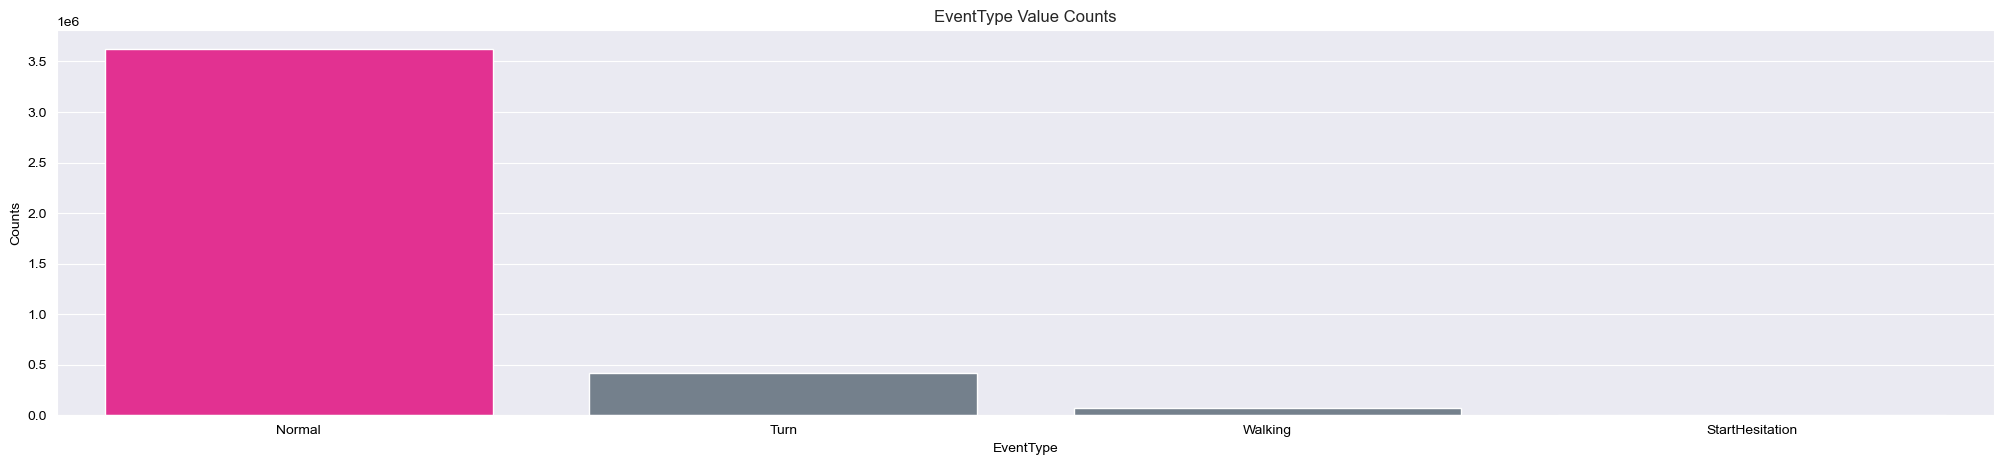

In [14]:
print(train_defog_valid['EventType'].value_counts())
plot_value_counts_bar_chart(train_defog_valid, 'EventType')

### Preprocessing and Exploring tDCSFOG Dataset

In [15]:
# Read in all tdcsfog train files. Creating time based features for window of 128 due to tDCSFOG files read in at 100Hz. Stride is at 64 so model can pick up time continuity in the overlap.

tdcsfog_files = Path(TDCSFOG_PATH).glob('*.csv')
train_tdcsfog = pd.concat(
    (pd.read_csv(f).assign(FileName=f.stem) for f in tdcsfog_files), 
    ignore_index=True
)
train_tdcsfog = reduce_memory_usage(train_tdcsfog)
train_tdcsfog.set_index(['FileName'], inplace=True)
train_tdcsfog

,Time,AccV,AccML,AccAP,StartHesitation,Turn,Walking
FileName,,,,,,,
003f117e14,0,-9.531250,0.566406,-1.413086,0,0,0
003f117e14,1,-9.539062,0.563965,-1.440430,0,0,0
003f117e14,2,-9.531250,0.561523,-1.429688,0,0,0
003f117e14,3,-9.531250,0.564453,-1.415039,0,0,0
003f117e14,4,-9.539062,0.562012,-1.429688,0,0,0
...,...,...,...,...,...,...,...
ffda8fadfd,4220,-9.406250,0.088989,-3.220703,0,0,0
ffda8fadfd,4221,-9.406250,0.090515,-3.216797,0,0,0
ffda8fadfd,4222,-9.406250,0.084351,-3.224609,0,0,0


In [16]:
# This takes forever to run, so uncommenting for now

# tdcsfog_acceleration_timesteps = train_tdcsfog[['Time', 'AccV', 'AccML', 'AccAP']].reset_index(drop=True).set_index('Time').stack().reset_index().rename(columns={'level_1': 'Acc', 0: 'Value'})
# plot_line_chart(tdcsfog_acceleration_timesteps, 'Time', 'Value', hue='Acc')

In [17]:
# Creating EventType target column, as a stacking of StartHesitation, Turn, and Walking columns
event_type_conditions = [
    (train_tdcsfog['StartHesitation'] == 1),
    (train_tdcsfog['Turn'] == 1),
    (train_tdcsfog['Walking'] == 1)
]
event_types = ['StartHesitation', 'Turn', 'Walking']
train_tdcsfog['EventType'] = np.select(
    event_type_conditions, 
    event_types, 
    default='Normal'
)
tdcsfog_le = LabelEncoder()
train_tdcsfog['Target'] = tdcsfog_le.fit_transform(train_tdcsfog['EventType'])

train_tdcsfog.drop(columns=event_types, inplace=True)

Normal             3626333
Turn                414380
Walking              70521
StartHesitation         88
Name: EventType, dtype: int64


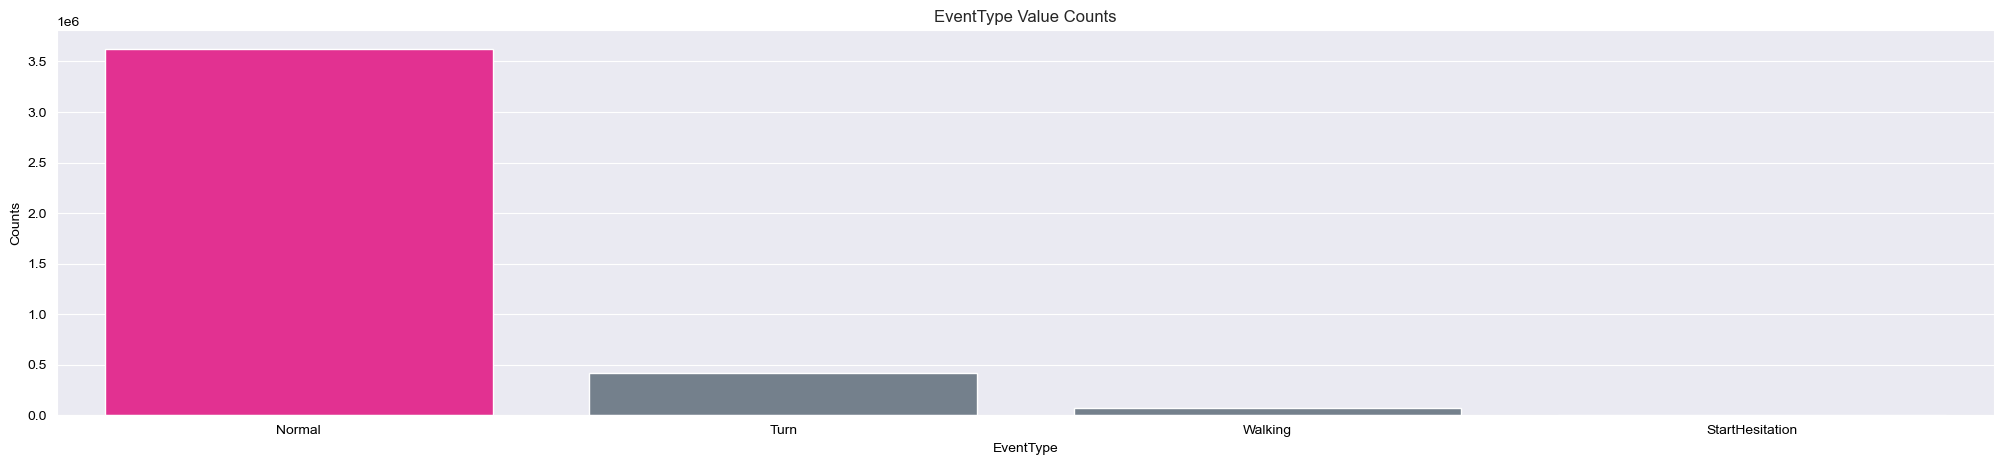

In [18]:
print(train_defog_valid['EventType'].value_counts())
plot_value_counts_bar_chart(train_defog_valid, 'EventType')

## Modeling XGBoost with Hyperopt and Evaluation

### Baseline Models

Creating a class makes it really easy to make the model for each dataset modular and consistent. Key things to note:
1. Using 'hist' for tree_method significantly speeds up training, but 'gpu_hist' is far better
2. 'multi:softprob' objective allows us to output probabilities
3. 'map' eval_metric ensures model is evaluated with mean average precision on validation data
4. In HyperOpt, our loss function is the weighted precision on our validation set due to high class imbalance

In [57]:
class XGBHyperopt:
    '''
    This class fits a XGBoost model with hyperparameters tuned with HyperOpt, given a dataset.
    '''
    def __init__(self, dataset: pd.DataFrame, weighted=False) -> None:
        self.dataset = dataset
        self.target = 'Target'
        self.search_space = {
            'tree_method': 'hist',
            'objective': 'multi:softprob',
            'eval_metric': 'map',
            'num_class': 4,
            'max_depth': scope.int(hp.quniform('max_depth', 4, 10, 1)),
            'subsample': hp.uniform('subsample', 0.6, 0.9),
            'learning_rate': hp.uniform('learning_rate', .001, 0.5),
            'min_child_weight': hp.quniform('min_child_weight', 1, 20, 1),
            'reg_alpha': hp.quniform('reg_alpha', 0, 1, .001),
            'reg_lambda': hp.quniform('reg_lambda', 0, 100, 1),
            'gamma': hp.uniform ('gamma', 1, 9),
            'verbosity': 1,
            'random_state': RANDOM_SEED
        }
        self.weighted = weighted        
        
    def preprocess(self, test_size=0.25, weighted=False):
        '''
        Splits the provided dataset into train and validation sets.
        '''
        X = self.dataset.drop(columns=[self.target])
        y = self.dataset[self.target].values

        # Splitting training/validation sets
        print('Splitting dataset into training and validation sets...')
        self.X_train, self.X_val, self.y_train, self.y_val = train_test_split(
            X, 
            y, 
            stratify=y,
            test_size=test_size,
            random_state=RANDOM_SEED
        )

    def evaluate_multiclassif_model(self, y_test, y_pred):

        """
        Creating evaluation metrics for classification predictions.

        Args:
            y_test: representing the true values of the target.
            y_pred: representing the predicted values of the target.
            y_pred_proba: representing the predicted probability values of the target.
        Returns:
            Dictionary of classification evaluation metrics
        """

        accuracy = accuracy_score(y_test, y_pred).round(3)
        # Getting weighted and macro averages of each below metric since task is multiclass classification
        weighted_precision = precision_score(y_test, y_pred, average='weighted', labels=np.unique(y_pred), zero_division=1).round(3)
        weighted_recall = recall_score(y_test, y_pred, average='weighted', labels=np.unique(y_pred), zero_division=1).round(3)
        weighted_f1 = f1_score(y_test, y_pred, average='weighted', labels=np.unique(y_pred), zero_division=1).round(3)
        
        macro_precision = precision_score(y_test, y_pred, average='macro', labels=np.unique(y_pred), zero_division=1).round(3)
        macro_recall = recall_score(y_test, y_pred, average='macro', labels=np.unique(y_pred), zero_division=1).round(3)
        macro_f1 = f1_score(y_test, y_pred, average='macro', labels=np.unique(y_pred), zero_division=1).round(3)

    #     print("Weighted Precision Score : ", weighted_precision)
    #     print("Macro Precision Score : ", macro_precision)

        return {
            'Accuracy': accuracy, 
            'Weighted Precision': weighted_precision, 
            'Weighted Recall': weighted_recall, 
            'Weighted F1': weighted_f1, 
            'Macro Precision': macro_precision, 
            'Macro Recall': macro_recall, 
            'Macro F1': macro_f1, 
        }

    def calibrate_best_model(self):
        self.best_calibrated_model = CalibratedClassifierCV(
            self.best_model, 
            method='isotonic', 
            cv='prefit'
        )
        self.best_calibrated_model = self.best_calibrated_model.fit(self.X_val, self.y_val)
        
    def hpopt_fit(self, calibrate=False):
        '''
        Sweeps the search space with a XGBoost model to minimize the loss function. Can be adapted to provide alternative loss functions to measure the validation set with.
        '''
        print('Modeling XGBoost with HyperOpt optimization...')
        def train_model(params):
            
            model = xgb.XGBClassifier(**params)
            if self.weighted:
                classes = np.unique(self.y_train)
                computed_class_weights = compute_class_weight(
                    class_weight='balanced', 
                    classes=classes,
                    y=self.y_train
                )
                class_weights_dict = {label: computed_class_weights[label] for label in classes}
                class_weights = pd.Series(self.y_train).map(class_weights_dict)
                model = model.fit(self.X_train, self.y_train, sample_weight=class_weights)
            else:
                model = model.fit(self.X_train, self.y_train)
            y_train_pred = model.predict(self.X_train)
            y_pred = model.predict(self.X_val)
            y_pred_proba = model.predict_proba(self.X_val)[:, 1]
            
            # Evaluating classification model evaluation metrics for testing set predictions and validation set predictions
            training_metrics = self.evaluate_multiclassif_model(self.y_train, y_train_pred)
            validation_metrics = self.evaluate_multiclassif_model(self.y_val, y_pred)

            # Set the loss to validation Weighted Precision so fmin maximizes the Weighted Precision
            return {
                'status': STATUS_OK, 
                'loss': -1*validation_metrics['Weighted Precision'],
                'model': model,
                'training_metrics': training_metrics,
                'validation_metrics': validation_metrics,
                'y_pred': y_pred,
                'y_pred_proba': y_pred_proba
            }
    
        self.trials = Trials()
        self.best_params = fmin(
            fn=train_model, 
            space=self.search_space, 
            algo=tpe.suggest, 
            max_evals=200,
            early_stop_fn=no_progress_loss(25),
            trials=self.trials
        )
        
        self.best_model = self.trials.results[np.argmin([r['loss'] for r in self.trials.results])]['model']
        if calibrate:
            self.calibrate_best_model()
            
    
    def validation_predictions(self):
        '''
        Returns the predictions and probabilities for the validation set
        '''
        self.y_pred = self.trials.results[np.argmin([r['loss'] for r in self.trials.results])]['y_pred']
        self.y_pred_proba = self.trials.results[np.argmin([r['loss'] for r in self.trials.results])]['y_pred_proba']
        predictions_df = pd.DataFrame([self.y_pred, self.y_pred_proba], columns=['predictions', 'probabilities'])
        return predictions_df
    
    def training_metrics(self):
        '''
        Returns the training metrics for the best model
        '''
        return self.trials.results[np.argmin([r['loss'] for r in self.trials.results])]['training_metrics']
    
    def validation_metrics(self):
        '''
        Returns the validation metrics for the best model
        '''
        return self.trials.results[np.argmin([r['loss'] for r in self.trials.results])]['validation_metrics']

    def predict(self, X_test):
        '''
        Returns the predictions for the test set
        '''
        return self.best_model.predict(X_test)
        
    def feature_importances(self):
        '''
        Returns the feature importances for the best model
        '''
        return self.best_model.feature_importances_

In [21]:
defog_baseline_dataset = train_defog_valid.reset_index(drop=True).drop(columns=['EventType']).set_index('Time')
tdcsfog_baseline_dataset = train_tdcsfog.reset_index(drop=True).drop(columns=['EventType']).set_index('Time')

In [22]:
defog_model = XGBHyperopt(defog_baseline_dataset)
defog_model.preprocess()
defog_model.hpopt_fit()

Splitting dataset into training and validation sets...
Modeling XGBoost with HyperOpt optimization...
 12%|█▎        | 25/200 [35:39<4:09:35, 85.58s/trial, best loss: -0.882]


In [23]:
defog_model.validation_metrics()

{'Accuracy': 0.882,
 'Weighted Precision': 0.882,
 'Weighted Recall': 1.0,
 'Weighted F1': 0.937,
 'Macro Precision': 0.882,
 'Macro Recall': 1.0,
 'Macro F1': 0.937}

In [24]:
tdcsfog_model = XGBHyperopt(tdcsfog_baseline_dataset)
tdcsfog_model.preprocess()
tdcsfog_model.hpopt_fit()

Splitting dataset into training and validation sets...
Modeling XGBoost with HyperOpt optimization...
 22%|██▎       | 45/200 [2:14:41<7:43:54, 179.58s/trial, best loss: -0.685] 


In [25]:
tdcsfog_model.validation_metrics()

{'Accuracy': 0.729,
 'Weighted Precision': 0.685,
 'Weighted Recall': 0.729,
 'Weighted F1': 0.681,
 'Macro Precision': 0.517,
 'Macro Recall': 0.328,
 'Macro F1': 0.334}

### Models with Feature Engineering and Calibration

In [22]:
def read_data_and_engineer_features(filename, w, s):
    '''
    Function to read in training file and create time series features using tsflex.
    Args:
        filename: filename of training data to read in
        w: window size
        s: stride size
    Returns:
        df: dataframe with time series features joined on
    '''
    
    df = pd.read_csv(filename, index_col=['Time']).assign(FileName=filename.stem)
    
    # reference: https://www.kaggle.com/code/jeroenvdd/time-series-tsflex
    basic_feats = MultipleFeatureDescriptors(
        functions=seglearn_feature_dict_wrapper(base_features()),
        series_names=['AccV', 'AccML', 'AccAP'],
        windows=[w],
        strides=[s],
    )

    emg_feats = emg_features()
    del emg_feats['simple square integral']

    emg_feats = MultipleFeatureDescriptors(
        functions=seglearn_feature_dict_wrapper(emg_feats),
        series_names=['AccV', 'AccML', 'AccAP'],
        windows=[w],
        strides=[s],
    )

    fc = FeatureCollection([basic_feats, emg_feats])
    df_ts = fc.calculate(
        df, 
        return_df=True, 
        include_final_window=True, 
        approve_sparsity=True, 
        window_idx='begin'
    ).astype(np.float32)
    
    df = df.join(df_ts, how='left')
    df.fillna(method='ffill', inplace=True)
    
    df = reduce_memory_usage(df)
    
    return df

In [114]:
# Reading in defog test file
defog_test_file = Path(DEFOG_TEST_PATH).glob('*.csv')
test_defog = pd.concat(
    (read_data_and_engineer_features(f, 100, 50) for f in defog_test_file), 
    ignore_index=True
)

test_defog.reset_index(inplace=True)
test_defog.rename(columns={'index': 'Time'}, inplace=True)
test_defog['Id'] = test_defog['FileName'].astype(str)+'_'+test_defog['Time'].astype(str)

# Reading in tdcsfog test file
tdcsfog_test_file = Path(TDCSFOG_TEST_PATH).glob('*.csv')
test_tdcsfog = pd.concat(
    (read_data_and_engineer_features(f, 128, 64) for f in tdcsfog_test_file), 
    ignore_index=True
)

test_tdcsfog.reset_index(inplace=True)
test_tdcsfog.rename(columns={'index': 'Time'}, inplace=True)
test_tdcsfog['Id'] = test_tdcsfog['FileName'].astype(str)+'_'+test_tdcsfog['Time'].astype(str)

In [23]:
# Reading in defog files and creating features for each file - 100 window size due to 100Hz and stride of 50 to ensure time continuity is captured via overlap
defog_files = Path(DEFOG_PATH).glob('*.csv')
train_defog_ts = pd.concat(
    (read_data_and_engineer_features(f, 100, 50) for f in defog_files), 
    ignore_index=True
)
train_defog_ts.set_index(['FileName'], inplace=True)

train_defog_ts = train_defog_ts[(train_defog_ts['Valid'] == 1) & (train_defog_ts['Task'] == 1)].drop(columns=['Valid', 'Task'])

# Creating EventType target column, as a stacking of StartHesitation, Turn, and Walking columns
event_type_conditions = [
    (train_defog_ts['StartHesitation'] == 1),
    (train_defog_ts['Turn'] == 1),
    (train_defog_ts['Walking'] == 1)
]
event_types = ['StartHesitation', 'Turn', 'Walking']
train_defog_ts['EventType'] = np.select(
    event_type_conditions, 
    event_types, 
    default='Normal'
)
defog_le = LabelEncoder()
train_defog_ts['Target'] = defog_le.fit_transform(train_defog_ts['EventType'])

train_defog_ts.drop(columns=event_types+['EventType'], inplace=True)

c:\Users\anima\anaconda3\envs\parkinsons_fog_kaggle\lib\site-packages\seglearn\feature_functions.py:185: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  return stats.skew(X, axis=1)
c:\Users\anima\anaconda3\envs\parkinsons_fog_kaggle\lib\site-packages\seglearn\feature_functions.py:190: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  return stats.kurtosis(X, axis=1)
c:\Users\anima\anaconda3\envs\parkinsons_fog_kaggle\lib\site-packages\seglearn\feature_functions.py:185: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  return stats.skew(X, axis=1)
c:\Users\anima\anaconda3\envs\parkinsons_fog_kaggle\lib\site-packages\segle

In [24]:
train_defog_ts

,AccV,AccML,AccAP,AccAP__abs_energy__w=100,AccAP__abs_sum__w=100,AccAP__emg_var__w=100,AccAP__kurt__w=100,AccAP__maximum__w=100,AccAP__mean__w=100,AccAP__mean_abs__w=100,...,AccV__mse__w=100,AccV__root_mean_square__w=100,AccV__skew__w=100,AccV__slope_sign_changes__w=100,AccV__std__w=100,AccV__var__w=100,AccV__waveform_length__w=100,AccV__willison_amplitude__w=100,AccV__zero_crossing__w=100,Target
FileName,,,,,,,,,,,,,,,,,,,,,
02ea782681,-0.970215,0.061615,-0.265625,5.906250,24.03125,0.059631,1.986328,-0.125000,-0.240234,0.240234,...,97.5625,0.987793,0.362061,57.0,0.036194,0.001310,0.842773,99.0,99.0,0
02ea782681,-0.984375,0.044495,-0.265625,5.906250,24.03125,0.059631,1.986328,-0.125000,-0.240234,0.240234,...,97.5625,0.987793,0.362061,57.0,0.036194,0.001310,0.842773,99.0,99.0,0
02ea782681,-0.984375,0.029022,-0.265625,5.906250,24.03125,0.059631,1.986328,-0.125000,-0.240234,0.240234,...,97.5625,0.987793,0.362061,57.0,0.036194,0.001310,0.842773,99.0,99.0,0
02ea782681,-0.984375,0.015625,-0.265625,5.906250,24.03125,0.059631,1.986328,-0.125000,-0.240234,0.240234,...,97.5625,0.987793,0.362061,57.0,0.036194,0.001310,0.842773,99.0,99.0,0
02ea782681,-0.984863,0.015327,-0.265625,5.906250,24.03125,0.059631,1.986328,-0.125000,-0.240234,0.240234,...,97.5625,0.987793,0.362061,57.0,0.036194,0.001310,0.842773,99.0,99.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
f9fc61ce85,-0.961426,0.142456,-0.289551,7.792969,27.90625,0.078735,-1.185547,-0.263916,-0.279053,0.279053,...,93.9375,0.969238,-0.425781,26.0,0.008698,0.000076,0.236328,99.0,99.0,0
f9fc61ce85,-0.960449,0.142822,-0.290527,7.792969,27.90625,0.078735,-1.185547,-0.263916,-0.279053,0.279053,...,93.9375,0.969238,-0.425781,26.0,0.008698,0.000076,0.236328,99.0,99.0,0
f9fc61ce85,-0.958008,0.145508,-0.290039,7.792969,27.90625,0.078735,-1.185547,-0.263916,-0.279053,0.279053,...,93.9375,0.969238,-0.425781,26.0,0.008698,0.000076,0.236328,99.0,99.0,0


In [25]:
# Reading in tdcsfog files and creating features for each file - 128 window size due to 128Hz and stride of 64 to ensure time continuity is captured via overlap
tdcsfog_files = Path(TDCSFOG_PATH).glob('*.csv')
train_tdcsfog_ts = pd.concat(
    (read_data_and_engineer_features(f, 128, 64) for f in tdcsfog_files), 
    ignore_index=True
)
train_tdcsfog_ts.set_index(['FileName'], inplace=True)

# Creating EventType target column, as a stacking of StartHesitation, Turn, and Walking columns
event_type_conditions = [
    (train_tdcsfog_ts['StartHesitation'] == 1),
    (train_tdcsfog_ts['Turn'] == 1),
    (train_tdcsfog_ts['Walking'] == 1)
]
event_types = ['StartHesitation', 'Turn', 'Walking']
train_tdcsfog_ts['EventType'] = np.select(
    event_type_conditions, 
    event_types, 
    default='Normal'
)
tdcsfog_le = LabelEncoder()
train_tdcsfog_ts['Target'] = tdcsfog_le.fit_transform(train_tdcsfog_ts['EventType'])

train_tdcsfog_ts.drop(columns=event_types+['EventType'], inplace=True)

In [26]:
train_tdcsfog_ts

,AccV,AccML,AccAP,AccAP__abs_energy__w=128,AccAP__abs_sum__w=128,AccAP__emg_var__w=128,AccAP__kurt__w=128,AccAP__maximum__w=128,AccAP__mean__w=128,AccAP__mean_abs__w=128,...,AccV__mse__w=128,AccV__root_mean_square__w=128,AccV__skew__w=128,AccV__slope_sign_changes__w=128,AccV__std__w=128,AccV__var__w=128,AccV__waveform_length__w=128,AccV__willison_amplitude__w=128,AccV__zero_crossing__w=128,Target
FileName,,,,,,,,,,,,,,,,,,,,,
003f117e14,-9.531250,0.566406,-1.413086,257.75,181.625,2.029297,-0.308105,-1.368164,-1.418945,1.418945,...,11632.0,9.531250,0.104980,81.0,0.004734,0.000022,0.491211,127.0,127.0,0
003f117e14,-9.539062,0.563965,-1.440430,257.75,181.625,2.029297,-0.308105,-1.368164,-1.418945,1.418945,...,11632.0,9.531250,0.104980,81.0,0.004734,0.000022,0.491211,127.0,127.0,0
003f117e14,-9.531250,0.561523,-1.429688,257.75,181.625,2.029297,-0.308105,-1.368164,-1.418945,1.418945,...,11632.0,9.531250,0.104980,81.0,0.004734,0.000022,0.491211,127.0,127.0,0
003f117e14,-9.531250,0.564453,-1.415039,257.75,181.625,2.029297,-0.308105,-1.368164,-1.418945,1.418945,...,11632.0,9.531250,0.104980,81.0,0.004734,0.000022,0.491211,127.0,127.0,0
003f117e14,-9.539062,0.562012,-1.429688,257.75,181.625,2.029297,-0.308105,-1.368164,-1.418945,1.418945,...,11632.0,9.531250,0.104980,81.0,0.004734,0.000022,0.491211,127.0,127.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ffda8fadfd,-9.406250,0.088989,-3.220703,690.00,211.750,10.781250,0.438965,-3.216797,-3.257812,3.257812,...,5740.0,9.398438,-0.164795,35.0,0.024689,0.000610,0.690918,64.0,64.0,0
ffda8fadfd,-9.406250,0.090515,-3.216797,690.00,211.750,10.781250,0.438965,-3.216797,-3.257812,3.257812,...,5740.0,9.398438,-0.164795,35.0,0.024689,0.000610,0.690918,64.0,64.0,0
ffda8fadfd,-9.406250,0.084351,-3.224609,690.00,211.750,10.781250,0.438965,-3.216797,-3.257812,3.257812,...,5740.0,9.398438,-0.164795,35.0,0.024689,0.000610,0.690918,64.0,64.0,0


In [63]:
defog_model_ts = XGBHyperopt(train_defog_ts)
defog_model_ts.preprocess()
defog_model_ts.hpopt_fit()

Splitting dataset into training and validation sets...
Modeling XGBoost with HyperOpt optimization...
 25%|██▌       | 50/200 [2:41:31<8:04:34, 193.83s/trial, best loss: -0.995] 


In [64]:
defog_model_ts.validation_metrics()

{'Accuracy': 0.995,
 'Weighted Precision': 0.995,
 'Weighted Recall': 0.995,
 'Weighted F1': 0.995,
 'Macro Precision': 0.969,
 'Macro Recall': 0.987,
 'Macro F1': 0.978}

In [65]:
tdcsfog_model_ts = XGBHyperopt(train_tdcsfog_ts)
tdcsfog_model_ts.preprocess()
tdcsfog_model_ts.hpopt_fit()

Splitting dataset into training and validation sets...
Modeling XGBoost with HyperOpt optimization...
 15%|█▌        | 30/200 [3:06:52<17:38:54, 373.73s/trial, best loss: -0.989]


In [66]:
tdcsfog_model_ts.validation_metrics()

{'Accuracy': 0.989,
 'Weighted Precision': 0.989,
 'Weighted Recall': 0.989,
 'Weighted F1': 0.988,
 'Macro Precision': 0.991,
 'Macro Recall': 0.981,
 'Macro F1': 0.986}

### Calibrate Models and Scale Weights

In [95]:
# Read in defog metadata file

metadata_defog = pd.read_csv(
    DEFOG_METADATA_PATH,
    index_col='Subject'
)
metadata_defog = reduce_memory_usage(metadata_defog)

# Read in tdcsfog metadata file

metadata_tdcsfog = pd.read_csv(
    TDCSFOG_METADATA_PATH,
    index_col='Subject'
)
metadata_tdcsfog = reduce_memory_usage(metadata_tdcsfog)

In [80]:
# Read in tasks file

tasks = pd.read_csv(
    f'{MAIN_ROOT}/tasks.csv',
    index_col='Id')
tasks = reduce_memory_usage(tasks)

tasks['Task Duration'] = tasks['End'] - tasks['Begin']
tasks = pd.pivot_table(
    tasks,
    values=['Task Duration'],
    index=['Id'],
    columns=['Task'],
    aggfunc='sum',
    fill_value=0
)

tasks.columns = tasks.columns.droplevel()

tasks

Task,4MW,4MW-C,Hotspot1,Hotspot1-C,Hotspot2,Hotspot2-C,MB1,MB10,MB11,MB12,...,MB8,MB9,Rest1,Rest2,TUG-C,TUG-DT,TUG-ST,Turning-C,Turning-DT,Turning-ST
Id,,,,,,,,,,,,,,,,,,,,,
02ab235146,16.500000,16.5000,18.0,16.0,54.0,64.0,14.0000,18.0,18.00,9.0,...,13.0,31.00,180.500,60.25,39.0,48.00,36.0000,22.0,46.0,24.0
02ea782681,11.625000,11.8125,11.0,11.0,9.0,9.0,3.3750,6.5,6.50,5.5,...,12.0,30.50,0.000,0.00,18.5,19.00,20.0000,18.0,22.0,19.0
06414383cf,24.875000,41.5625,25.5,0.0,38.0,0.0,0.0000,0.0,0.00,0.0,...,0.0,0.00,0.000,0.00,0.0,45.00,33.8750,0.0,83.5,124.5
092b4c1819,13.656250,0.0000,15.0,0.0,35.0,0.0,0.0000,0.0,0.00,0.0,...,0.0,0.00,0.000,0.00,0.0,30.00,23.4375,0.0,45.0,39.5
0a900ed8a2,11.750000,11.7500,11.0,11.0,44.0,41.0,1.5000,21.0,10.00,5.0,...,31.5,30.50,180.875,60.25,18.0,25.00,19.0000,19.0,19.0,16.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
f3a921edee,16.718750,0.0000,16.5,0.0,76.0,0.0,0.0000,0.0,0.00,0.0,...,0.0,0.00,0.000,0.00,0.0,28.75,29.9375,0.0,137.0,77.0
f40e8c6ebe,12.859375,0.0000,28.0,0.0,152.0,0.0,0.0000,0.0,0.00,0.0,...,0.0,0.00,0.000,0.00,0.0,36.75,28.2500,0.0,98.5,69.5
f8ddbdd98d,23.781250,0.0000,32.0,0.0,39.0,0.0,6.3750,10.5,10.75,11.0,...,0.0,33.25,0.000,0.00,0.0,44.00,55.0000,0.0,100.0,72.0


In [99]:
defog_non_ts = subjects.join(metadata_defog, how='left', rsuffix='_metadata') \
    .reset_index() \
        .set_index(['Id']) \
            .join(tasks, how='left')

defog_non_ts['Sex'] = np.where(defog_non_ts['Sex'] == 'M', 1, 0)
defog_non_ts['Medication'] = np.where(defog_non_ts['Medication'] == 'on', 1, 0)
defog_non_ts = defog_non_ts.rename(columns={'Sex': 'Sex_male', 'Medication': 'Medication_on'})

tdcsfog_non_ts = subjects.join(metadata_tdcsfog, how='left', rsuffix='_metadata') \
    .reset_index() \
        .set_index(['Id']) \
            .join(tasks, how='left')

tdcsfog_non_ts['Sex'] = np.where(tdcsfog_non_ts['Sex'] == 'M', 1, 0)
tdcsfog_non_ts['Medication'] = np.where(tdcsfog_non_ts['Medication'] == 'on', 1, 0)
tdcsfog_non_ts = tdcsfog_non_ts.rename(columns={'Sex': 'Sex_male', 'Medication': 'Medication_on'})

In [107]:
defog_ts_features = [col for col in train_defog_ts.columns if col != 'Target']
tdcsfog_ts_features = [col for col in train_tdcsfog_ts.columns if col != 'Target']
defog_non_ts_features = [col for col in defog_non_ts.columns.tolist() if col not in ['Subject', 'Visit', 'Visit_metadata']]
tdcsfog_non_ts_features = [col for col in tdcsfog_non_ts.columns.tolist() if col not in ['Subject', 'Visit', 'Visit_metadata']]

In [108]:
train_defog_feateng = train_defog_ts.join(defog_non_ts, how='left').fillna(0).reset_index(drop=True)[defog_ts_features+defog_non_ts_features+['Target']]
train_tdcsfog_feateng = train_tdcsfog_ts.join(tdcsfog_non_ts, how='left').fillna(0).reset_index(drop=True)[tdcsfog_ts_features+tdcsfog_non_ts_features+['Target']]

In [109]:
defog_model_feateng_calibrated = XGBHyperopt(train_defog_feateng, weighted=True)
defog_model_feateng_calibrated.preprocess()
defog_model_feateng_calibrated.hpopt_fit(calibrate=True)
defog_model_feateng_calibrated = defog_model_feateng_calibrated.best_calibrated_model

Splitting dataset into training and validation sets...
Modeling XGBoost with HyperOpt optimization...
 24%|██▎       | 47/200 [5:26:40<17:43:26, 417.04s/trial, best loss: -0.995]


In [110]:
tdcsfog_model_feateng_calibrated = XGBHyperopt(train_tdcsfog_feateng, weighted=True)
tdcsfog_model_feateng_calibrated.preprocess()
tdcsfog_model_feateng_calibrated.hpopt_fit(calibrate=True)
tdcsfog_model_feateng_calibrated = tdcsfog_model_feateng_calibrated.best_calibrated_model

Splitting dataset into training and validation sets...
Modeling XGBoost with HyperOpt optimization...
 24%|██▎       | 47/200 [6:34:30<21:24:14, 503.62s/trial, best loss: -0.995]


## Predict on Test Set and Submit

In [145]:
test_defog_feateng = test_defog.drop_duplicates() \
    .set_index('FileName') \
        .join(defog_non_ts, how='left') \
            .reset_index(drop=True) \
                .drop(columns=['Time', 'Subject', 'Visit', 'Visit_metadata'])
test_tdcsfog_feateng = test_tdcsfog.drop_duplicates() \
    .set_index('FileName') \
        .join(tdcsfog_non_ts, how='left') \
            .reset_index(drop=True) \
                .drop(columns=['Time', 'Subject', 'Visit', 'Visit_metadata'])

test_defog_feateng.shape, test_tdcsfog_feateng.shape

((563376, 99), (4682, 100))

In [150]:
test_defog_feateng['predictions'] = defog_model_feateng_calibrated.predict(test_defog_feateng.drop(columns=['Id']))
test_tdcsfog_feateng['predictions'] = tdcsfog_model_feateng_calibrated.predict(test_tdcsfog_feateng.drop(columns=['Id']))

test_defog_feateng['predictions'] = defog_le.inverse_transform(test_defog_feateng['predictions'])
test_tdcsfog_feateng['predictions'] = tdcsfog_le.inverse_transform(test_tdcsfog_feateng['predictions'])

test_defog_predictions = test_defog_feateng[['Id', 'predictions']]
test_tdcsfog_predictions = test_tdcsfog_feateng[['Id', 'predictions']]

defog_submissions = test_defog_predictions.groupby(['Id', 'predictions']).size().unstack(fill_value=0)
tdcsfog_submissions = test_tdcsfog_predictions.groupby(['Id', 'predictions']).size().unstack(fill_value=0)

In [158]:
defog_non_ts[defog_non_ts.index == '02ab235146']

,Subject,Visit,Age,Sex_male,YearsSinceDx,UPDRSIII_On,UPDRSIII_Off,NFOGQ,Visit_metadata,Medication_on,...,MB8,MB9,Rest1,Rest2,TUG-C,TUG-DT,TUG-ST,Turning-C,Turning-DT,Turning-ST
Id,,,,,,,,,,,,,,,,,,,,,
02ab235146,ab54e1,1.0,79,0,8.0,52.0,55.0,28,2.0,1,...,13.0,31.0,180.5,60.25,39.0,48.0,36.0,22.0,46.0,24.0
02ab235146,ab54e1,2.0,79,0,8.0,38.0,64.0,28,2.0,1,...,13.0,31.0,180.5,60.25,39.0,48.0,36.0,22.0,46.0,24.0


In [161]:
tdcsfog_non_ts[tdcsfog_non_ts.index == '003f117e14']

,Subject,Visit,Age,Sex_male,YearsSinceDx,UPDRSIII_On,UPDRSIII_Off,NFOGQ,Visit_metadata,Test,...,MB8,MB9,Rest1,Rest2,TUG-C,TUG-DT,TUG-ST,Turning-C,Turning-DT,Turning-ST
Id,,,,,,,,,,,,,,,,,,,,,
003f117e14,13abfd,NaN,68,0,9.0,17.0,15.0,15,3.0,2.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [73]:
defog_submissions['StartHesitation'] = 0
defog_submissions['Walking'] = 0

defog_submissions = defog_submissions[['StartHesitation', 'Turn', 'Walking']]
defog_submissions

predictions,StartHesitation,Turn,Walking
Id,,,
02ab235146_0,0,0,0
02ab235146_1,0,0,0
02ab235146_10,0,0,0
02ab235146_100,0,0,0
02ab235146_1000,0,0,0
...,...,...,...
02ab235146_99995,0,0,0
02ab235146_99996,0,0,0
02ab235146_99997,0,0,0


In [75]:
tdcsfog_submissions['StartHesitation'] = 0
tdcsfog_submissions['Walking'] = 0

tdcsfog_submissions = tdcsfog_submissions[['StartHesitation', 'Turn', 'Walking']]
tdcsfog_submissions

predictions,StartHesitation,Turn,Walking
Id,,,
003f117e14_0,0,0,0
003f117e14_1,0,0,0
003f117e14_10,0,0,0
003f117e14_100,0,0,0
003f117e14_1000,0,0,0
...,...,...,...
003f117e14_995,0,0,0
003f117e14_996,0,0,0
003f117e14_997,0,0,0


In [79]:
pd.concat([defog_submissions, tdcsfog_submissions]).to_csv('submission.csv')